# Data Challenge NLP, X-Natixis : Prediction of VIX using Central banks speeches

In [ ]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt

### Download required files if needed

In [ ]:
# Train data
!pip install --upgrade --no-cache-dir gdown --quiet
!gdown 1CA4obGlDXfpk_ZWe758idTzvhDkUQPDy
!gdown 1PMOTlRopWR5Jzf06Vb5GinVZubXyalEB

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Downloading...
From: https://drive.google.com/uc?id=1CA4obGlDXfpk_ZWe758idTzvhDkUQPDy
To: /content/VIX_1w.json
100% 263M/263M [00:03<00:00, 75.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PMOTlRopWR5Jzf06Vb5GinVZubXyalEB
To: /content/EURUSDV1M_1w.json
100% 263M/263M [00:03<00:00, 79.4MB/s]


In [ ]:
# test data
!pip install --upgrade --no-cache-dir gdown --quiet
!gdown 1QyZ07R-o64pgqC6COfhijLTeLOPPzRtM
!gdown 1d0YuD1dzsLd2ke__h5qZwOJbGwm3gF-b
!gdwon 11bbSx8QSMPb9-k8JMSVLY-HYAWNEuurH
!gdown 1v1TsrK9uX_LvoFAbHLASGM9XZPYmxUyD

Downloading...
From: https://drive.google.com/uc?id=1QyZ07R-o64pgqC6COfhijLTeLOPPzRtM
To: /content/test_VIX_1w.json
100% 30.4M/30.4M [00:00<00:00, 46.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1d0YuD1dzsLd2ke__h5qZwOJbGwm3gF-b
To: /content/test_EURUSDV1M_1w.json
100% 30.4M/30.4M [00:00<00:00, 44.0MB/s]


### Collecting data

In [ ]:
train_vix_json = 'VIX_1w.json'
train_eur_json = 'EURUSDV1M_1w.json'

with open(train_vix_json, 'r') as json_file:
    train_vix = json.load(json_file)

with open(train_eur_json, 'r') as json_file:
    train_eur = json.load(json_file)

In [ ]:
test_vix_json = 'test_VIX_1w.json'
test_eur_json = 'test_EURUSDV1M_1w.json'

with open(test_vix_json, 'r') as json_file:
    test_vix = json.load(json_file)

with open(test_eur_json, 'r') as json_file:
    test_eur = json.load(json_file)

In [ ]:
y_test_vix_json = 'VIX_1w_truth.json'
y_test_eur_json = 'EURUSDV1M_1w_truth.json'

with open(test_vix_json, 'r') as json_file:
  y_test_vix = json.load(json_file)

with open(test_eur_json, 'r') as json_file:
  y_test_eur = json.load(json_file)

### Get unique speech list

In [ ]:
def process_json(json_data):
  for individual in json_data:
    for day_of_speech in individual['speech']:
      for bank in day_of_speech.keys():
        day_of_speech[bank] = '' if len(day_of_speech[bank])==0 else day_of_speech[bank][0].strip('\" ')

process_json(train_vix)
process_json(train_eur)

process_json(test_vix)
process_json(test_eur)

In [ ]:
def get_list_speeches(data, bank='FED'):
  N = len(data)
  T = 20
    
  speech_set = set()
  speech_list = []

  for sample in range(N):
    for day in range(T):
      speech = data[sample]['speech'][day][bank]
      if (speech not in speech_set) and (len(speech) != 0):
        speech_set.add(speech)
        speech_list.append(speech)
  
  return speech_list

fed_speech_vix = get_list_speeches(train_vix, bank='FED')
ecb_speech_vix = get_list_speeches(train_vix, bank='ECB')

fed_speech_eur = get_list_speeches(train_eur, bank='FED')
ecb_speech_eur = get_list_speeches(train_eur, bank='ECB')

test_fed_speech_vix = get_list_speeches(test_vix, bank='FED')
test_ecb_speech_vix = get_list_speeches(test_vix, bank='ECB')

test_fed_speech_eur = get_list_speeches(test_eur, bank='FED')
test_ecb_speech_eur = get_list_speeches(test_eur, bank='ECB')

In [ ]:
print(len(ecb_speech_vix))
print(len(fed_speech_vix))

print(len(ecb_speech_eur))
print(len(fed_speech_eur))

1262
417
1262
417


### Construct X_train, y_train

In [ ]:
def build_dataset(data, fed_list=None, ecb_list=None, labels=True):

    N = len(data)
    T = 20
    banks = ['ECB', 'FED']
    X = np.empty((N, 3), dtype=object)
    y = np.empty((N, 2))
    
    if fed_list is None:
      fed_list = get_list_speeches(data, bank='FED')
    if ecb_list is None:
      ecb_list = get_list_speeches(data, bank='ECB')

    for i in range(len(data)):
        idx_ecb = []
        idx_fed = []
        for day in range(T):
          for b in banks:
            speech = data[i]['speech'][day][b] 
            if (len(speech) == 0) or (speech not in eval(b.lower()+"_list")):
              eval("idx_"+b.lower()).append(0)
            else:
              eval("idx_"+b.lower()).append(eval(b.lower()+"_list").index(speech))

        X[i, 0] = np.array(data[i]['stock'])
        X[i, 1] = np.array(idx_fed)
        X[i, 2] = np.array(idx_ecb)
        
        if labels:
            y[i, 0] = data[i]['target_reg']
            y[i, 1] = data[i]['target_classif']

    return X, y

In [ ]:
X_train_vix, y_train_vix = build_dataset(train_vix)
X_train_eur, y_train_eur = build_dataset(train_eur)

X_test_vix, _ = build_dataset(test_vix, labels=False)
X_test_eur, _ = build_dataset(test_eur, labels=False)

print(X_train_vix[0])
print(y_train_vix[0])

[array([-0.47295821, -0.17240761, -0.19455345, -0.20931734, -0.15237091,
        -0.19666258, -0.12073401, -0.22829948, -0.11335206, -0.0342598 ,
        -0.17662586,  0.14607055,  0.29476401,  0.20196241,  0.00581361,
        -0.11335206, -0.14920722, -0.06800583,  0.12287015,  0.06592373])
 array([0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0])
 array([ 0,  1,  0,  0,  2,  3,  4,  5,  6,  0,  0,  7,  0,  0,  0,  8,  0,
         0,  9, 10])                                                       ]
[-0.40862983  0.        ]


## Languages

#### Identify languages and compute them

In [ ]:
!pip install langdetect

     |████████████████████████████████| 981 kB 29.5 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=0d0a59812f2e8b7fedc817b6cbe5153d33e9048db3c9e310bf7e86f91b6aebb4
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [ ]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

def get_languages(speech_list):
  lang = []
  for speech in speech_list:
    lang.append(detect(speech))
  return np.array(lang)

In [ ]:
lang_fed_vix = get_languages(fed_speech_vix)
lang_ecb_vix = get_languages(ecb_speech_vix)
print(f"FED speeches language : {np.unique(lang_fed_vix, return_counts=True)}")
print(f"ECB speeches language : {np.unique(lang_ecb_vix, return_counts=True)}")

FED speeches language : (array(['de', 'en', 'es', 'fr'], dtype='<U2'), array([ 10, 399,   4,   4]))
ECB speeches language : (array(['de', 'en', 'es', 'fr', 'it'], dtype='<U2'), array([  45, 1197,   12,    5,    3]))


In [ ]:
lang_fed_eur = get_languages(fed_speech_eur)
lang_ecb_eur = get_languages(ecb_speech_eur)
print(f"FED speeches language : {np.unique(lang_fed_eur, return_counts=True)}")
print(f"ECB speeches language : {np.unique(lang_ecb_eur, return_counts=True)}")

FED speeches language : (array(['de', 'en', 'es', 'fr'], dtype='<U2'), array([ 10, 399,   4,   4]))
ECB speeches language : (array(['de', 'en', 'es', 'fr', 'it'], dtype='<U2'), array([  45, 1197,   12,    5,    3]))


#### Delete speeches with other languages

In [ ]:
fed_speech_vix = np.array(fed_speech_vix)[lang_fed_vix == 'en']
ecb_speech_vix = np.array(ecb_speech_vix)[lang_ecb_vix == 'en']

fed_speech_eur = np.array(fed_speech_eur)[lang_fed_eur == 'en']
ecb_speech_eur = np.array(ecb_speech_eur)[lang_ecb_eur == 'en']

print(len(ecb_speech_vix))
print(len(fed_speech_vix))

1197
399


In [ ]:
fed_speech_vix = list(fed_speech_vix)
ecb_speech_vix = list(ecb_speech_vix)

fed_speech_eur = list(fed_speech_eur)
ecb_speech_eur = list(ecb_speech_eur)

X_train_vix, y_train_vix = build_dataset(train_vix, fed_list=fed_speech_vix, ecb_list=ecb_speech_vix)
X_train_eur, y_train_eur = build_dataset(train_eur, fed_list=fed_speech_eur, ecb_list=ecb_speech_eur)

## Summarization

### 1/ With NLTK, using basic sentences scores 

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Get best k sentences based on word frequencies

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

def weight_freq(speech):
    stop_words = stopwords.words('english')
    word_frequencies = {}
    for word in word_tokenize(speech):
        if word not in stop_words:
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1

    maximum_frequncy = max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)

    return word_frequencies


def sent_score(sent_speech, word_freq):
    sentence_scores = {}
    for sent in sent_speech:
        for word in word_tokenize(sent.lower()):
            if word in word_freq.keys():
                if len(sent.split(' ')) < 50:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_freq[word]
                    else:
                        sentence_scores[sent] += word_freq[word]
    return sentence_scores

import heapq

def get_summary(sent_scores, top_sent):
    summary_sentences = heapq.nlargest(top_sent, sent_scores, key=sent_scores.get)
    summary = ' '.join(summary_sentences)
    return summary

def summarize(speech, top_sent=8):
    word_freq = weight_freq(speech)
    scores_sent = sent_score(sent_tokenize(speech), word_freq)
    summ = get_summary(scores_sent, top_sent)

    return summ

# example with one speech
se = 0
s = summarize(fed_speech_vix[se], 12)
s

'Jiménez, G., Ongena, S., Peydró and J. Saurina (2011), Macroprudential Policy, Countercyclical Bank Capital Buffers and Credit Supply: Evidence from the Spanish Dynamic Provisioning Experiments, Bank of Spain mimeo. Hellmann, T., Murdock, K. and J. Stiglitz (2000), Liberalization, Moral Hazard in Banking, and Prudential Regulation: Are Capital Requirements Enough?, American Economic Review. [5]See Mian and Sufi (2009); Maddaloni and Peydró (2011); Jiménez, Mian, Peydró and Sufi (2011), Altunbas, Marqués and Gambacorta (2010). Banks’ capital reserves, transparency, funding, risk management, corporate governance and both micro and, especially, macro supervision and regulation need to be adjusted. On that same subject, we should welcome the changes made to EU and global banking regulations and supervision, both micro and macro-based: for example, the Basel III package of regulations (level and quality of capital, countercyclical buffers of capital, liquidity ratio. Matutes, C. and X. Viv

#### Compute a summary for each speech :

In [ ]:
fed_speech_sum_vix = []
ecb_speech_sum_vix = []

banks = ['ECB', 'FED']

# ~2min run
for b in banks:
    for speech in eval(b.lower()+"_speech_vix"):
        eval(b.lower()+"_speech_sum_vix").append(summarize(speech, 12))

In [ ]:
fed_speech_sum_eur = []
ecb_speech_sum_eur = []

banks = ['ECB', 'FED']

# ~2min run
for b in banks:
    for speech in eval(b.lower()+"_speech_eur"):
        eval(b.lower()+"_speech_sum_eur").append(summarize(speech, 12))

Test set

In [ ]:
test_fed_speech_sum_vix = []
test_ecb_speech_sum_vix = []

banks = ['ECB', 'FED']

# ~2min run
for b in banks:
    for speech in eval("test_"+b.lower()+"_speech_vix"):
        eval("test_"+b.lower()+"_speech_sum_vix").append(summarize(speech, 12))

In [ ]:
test_fed_speech_sum_eur = []
test_ecb_speech_sum_eur = []

banks = ['ECB', 'FED']

# ~2min run
for b in banks:
    for speech in eval("test_"+b.lower()+"_speech_eur"):
        eval("test_"+b.lower()+"_speech_sum_eur").append(summarize(speech, 12))

## Embeddings

### Compute embeddings with sentence transformers

In [ ]:
%%capture
!pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer

def get_embeddings(model_name, speech_list, max_length, verbose=True):

    embeddings = []
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = SentenceTransformer(model_name, device=device)
    model.max_seq_length = max_length
    for speech in speech_list:
      sentences = sent_tokenize(speech)
      embeddings.append(model.encode(sentences, convert_to_numpy=True, 
                                     batch_size=128, show_progress_bar=verbose))
    return embeddings


In [ ]:
model_name = 'msmarco-MiniLM-L-6-v3'

fed_sentences_embeddings_eur = get_embeddings(model_name, fed_speech_eur, 512, verbose=False)
ecb_sentences_embeddings_eur = get_embeddings(model_name, ecb_speech_eur, 512, verbose=False)

In [ ]:
from sentence_transformers import util

model_name = 'msmarco-MiniLM-L-6-v3'
model = SentenceTransformer(model_name)
query = model.encode('Will the stock market index value go up or down, what is the trend ?')

top_sentences = []
top_scores, true_sent = [], []
all_sentences = fed_sentences_embeddings_eur + ecb_sentences_embeddings_eur
all_speech = fed_speech_eur + ecb_speech_eur
for i, speech in enumerate(all_sentences):
  sents = sent_tokenize(all_speech[i])
  scores = util.cos_sim(query, speech)
  if scores.size(1) >= 5:
    cosine, indices = torch.topk(scores, 5)
    indices = indices.tolist()[0]
  else:
    indices = [0] * 5
  top_scores.append(cosine.tolist()[0])
  top_sentences.append(np.take(speech, indices, axis=0))
  true_sent.append([sents[idx] for idx in indices])

In [ ]:
final_embeddings = np.array(top_sentences)
final_embeddings.shape

(1596, 5, 384)

In [ ]:
final_cosine = np.array(top_scores)
final_cosine.shape

(1596, 5)

test set

In [ ]:
model_name = 'msmarco-MiniLM-L-6-v3'

test_fed_sentences_embeddings_eur = get_embeddings(model_name, test_fed_speech_eur, 512, verbose=False)
test_ecb_sentences_embeddings_eur = get_embeddings(model_name, test_ecb_speech_eur, 512, verbose=False)

In [ ]:
from sentence_transformers import util

model_name = 'msmarco-MiniLM-L-6-v3'
model = SentenceTransformer(model_name)
query = model.encode('Will the stock market index value go up or down, what is the trend ?')

test_top_sentences = []
test_top_scores, test_true_sent = [], []
all_sentences = test_fed_sentences_embeddings_eur + test_ecb_sentences_embeddings_eur
all_speech = test_fed_speech_eur + test_ecb_speech_eur
for i, speech in enumerate(all_sentences):
  sents = sent_tokenize(all_speech[i])
  scores = util.cos_sim(query, speech)
  if scores.size(1) >= 5:
    cosine, indices = torch.topk(scores, 5)
    indices = indices.tolist()[0]
  else:
    indices = [0] * 5
  test_top_scores.append(cosine.tolist()[0])
  test_top_sentences.append(np.take(speech, indices, axis=0))
  test_true_sent.append([sents[idx] for idx in indices])

In [ ]:
test_final_embeddings = np.array(test_top_sentences)
test_final_embeddings.shape

(262, 5, 384)

In [ ]:
test_final_cosine = np.array(test_top_scores)
test_final_cosine.shape

(262, 5)

### Save embeddings 

In [ ]:
with open('final_embed.npy', 'wb') as f:
  np.save(f, final_embeddings)

In [ ]:
with open('final_cosine.npy', 'wb') as f:
  np.save(f, final_cosine)

In [ ]:
with open('test_final_embed.npy', 'wb') as f:
  np.save(f, test_final_embeddings)

In [ ]:
with open('test_final_cosine.npy', 'wb') as f:
  np.save(f, test_final_cosine)

## Perform classification on speeches

### Using a sentiment analysis pipeline on summaries

In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline

model = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
clf = pipeline("sentiment-analysis", model=model, truncation=True)
res_fed_eur = clf(fed_speech_sum_eur)
res_ecb_eur = clf(ecb_speech_sum_eur)

In [ ]:
def convert_sentiment(res):
  labels = []
  for dico in res:
    if dico['label'] == 'neutral':
      labels.append(0)
    elif dico['label'] == 'positive':
      labels.append(1)
    else:
      labels.append(-1)
  return labels

y_fed_fine_eur = convert_sentiment(res_fed_eur)
y_ecb_fine_eur = convert_sentiment(res_ecb_eur)

In [ ]:
final_y_fine = np.array(y_fed_fine_eur + y_ecb_fine_eur)
final_y_fine.shape

(1596,)

In [ ]:
with open('final_y_fine.npy', 'wb') as f:
  np.save(f, final_y_fine)

Test set

In [ ]:
test_res_fed_eur = clf(test_fed_speech_sum_eur)
test_res_ecb_eur = clf(test_ecb_speech_sum_eur)

In [ ]:
test_y_fed_fine_eur = convert_sentiment(test_res_fed_eur)
test_y_ecb_fine_eur = convert_sentiment(test_res_ecb_eur)

In [ ]:
test_final_y_fine = np.array(test_y_fed_fine_eur + test_y_ecb_fine_eur)
test_final_y_fine.shape

(262,)

In [ ]:
with open('test_final_y_fine.npy', 'wb') as f:
  np.save(f, test_final_y_fine)

### Classifiy pre selected sentences

In [ ]:
model = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
clf = pipeline("sentiment-analysis", model=model, truncation=True)
sentiments = []
for sentences in true_sent:
  res = clf(sentences)
  sentiments.append(
      convert_sentiment(res)
  )

In [ ]:
for i, seq in enumerate(sentiments):
  if len(seq)==0:
    sentiments[i] = [0] * 5

In [ ]:
final_sentiments = np.array(sentiments)
final_sentiments.shape

(1596, 5)

In [ ]:
with open('final_sentiments.npy', 'wb') as f:
  np.save(f, final_sentiments)

Test set

In [ ]:
model = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
clf = pipeline("sentiment-analysis", model=model, truncation=True)
test_sentiments = []
for sentences in test_true_sent:
  res = clf(sentences)
  test_sentiments.append(
      convert_sentiment(res)
  )

In [ ]:
for i, seq in enumerate(test_sentiments):
  if len(seq)==0:
    test_sentiments[i] = [0] * 5

In [ ]:
test_final_sentiments = np.array(test_sentiments)
test_final_sentiments.shape

(262, 5)

In [ ]:
with open('test_final_sentiments.npy', 'wb') as f:
  np.save(f, test_final_sentiments)

## Prepare dataset

In [ ]:
# Retrieve features VIX
# train
!pip install --upgrade --no-cache-dir gdown --quiet
!gdown 1AqbEgGMaIIZVJGIXjaPHE6U4N-0Z99jq # embeddings
!gdown 1jOKnlcT1q-XZ6ext3BBb4dN0N5okQLsS # sentiment summary
!gdown 1kf8K43HbDEvnO8hA90kxa-f_dUKBKoN8 # setiment sentences pre selected
!gdown 1gZmf8Hkd85rRKyUj0h5a0eWeDTGwUjrk # cosine scores of those

# test
!gdown 1VaLWPfxzrg-DQg-N7qdz9BMZPYEB5eau
!gdown 1grzidEJebyqOmmcJG0dPgI-DRjHSlxN1
!gdown 1GWoDmljmCMpGT_leyXbgIvoJFF0I6LFr
!gdown 1WAdZfsfDI4DQqtBuk6rMkh94gsXPIMQe

Downloading...
From: https://drive.google.com/uc?id=1AqbEgGMaIIZVJGIXjaPHE6U4N-0Z99jq
To: /content/final_embed.npy
100% 12.3M/12.3M [00:00<00:00, 73.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jOKnlcT1q-XZ6ext3BBb4dN0N5okQLsS
To: /content/final_y_fine.npy
100% 12.9k/12.9k [00:00<00:00, 18.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kf8K43HbDEvnO8hA90kxa-f_dUKBKoN8
To: /content/final_sentiments.npy
100% 64.0k/64.0k [00:00<00:00, 7.80MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gZmf8Hkd85rRKyUj0h5a0eWeDTGwUjrk
To: /content/final_cosine.npy
100% 64.0k/64.0k [00:00<00:00, 8.23MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VaLWPfxzrg-DQg-N7qdz9BMZPYEB5eau
To: /content/test_final_embed.npy
100% 2.01M/2.01M [00:00<00:00, 38.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1grzidEJebyqOmmcJG0dPgI-DRjHSlxN1
To: /content/test_final_y_fine.npy
100% 2.22k/2.22k [00:00<00:00, 3.23MB/s]
Downloading...
From: https://drive.google.com/

In [ ]:
# Retrieve features EUR
# train
!pip install --upgrade --no-cache-dir gdown --quiet
!gdown 1ubj4pwQz-kY8v7BreP3aS8Cb84vLJxbZ
!gdown 1DfNsVj6p9pDc4aPo1ZiY-jjXgfG9Y4FN
!gdown 1W9PkF3vvtI3UWKUTgbJKXYHEVU78J98L
!gdown 1s_u64dxVwg1l4zZRaXGtJ2LIXE_XvZEv

# test
!gdown 1uk7v4jgN5tLNroemeRRHQYEfYmziw6a1
!gdown 1wbl8vUU8e3pDkXb4cAirc8Et5J4N7iDB
!gdown 1c7P2eMZtqBJ7s2_eOzm-0ZQ0zq9Ahdfg
!gdown 1dUS51uMZRMUTVqX6DUBC4DOjsIy6IAuU

Downloading...
From: https://drive.google.com/uc?id=1ubj4pwQz-kY8v7BreP3aS8Cb84vLJxbZ
To: /content/final_embed.npy
100% 12.3M/12.3M [00:00<00:00, 25.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DfNsVj6p9pDc4aPo1ZiY-jjXgfG9Y4FN
To: /content/final_y_fine.npy
100% 12.9k/12.9k [00:00<00:00, 14.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1W9PkF3vvtI3UWKUTgbJKXYHEVU78J98L
To: /content/final_sentiments.npy
100% 64.0k/64.0k [00:00<00:00, 14.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1s_u64dxVwg1l4zZRaXGtJ2LIXE_XvZEv
To: /content/final_cosine.npy
100% 64.0k/64.0k [00:00<00:00, 8.06MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uk7v4jgN5tLNroemeRRHQYEfYmziw6a1
To: /content/test_final_embed.npy
100% 2.01M/2.01M [00:00<00:00, 40.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wbl8vUU8e3pDkXb4cAirc8Et5J4N7iDB
To: /content/test_final_y_fine.npy
100% 2.22k/2.22k [00:00<00:00, 3.17MB/s]
Downloading...
From: https://drive.google.com/

In [ ]:
final_embeddings = np.load('final_embed.npy')
final_y_fine = np.load('final_y_fine.npy')
final_sentiments = np.load('final_sentiments.npy')
final_cosine = np.load('final_cosine.npy')

test_final_embeddings = np.load('test_final_embed.npy')
test_final_y_fine = np.load('test_final_y_fine.npy')
test_final_sentiments = np.load('test_final_sentiments.npy')
test_final_cosine = np.load('test_final_cosine.npy')

In [ ]:
def create_dataset(X, y, n_fed=399, embeddings=None, 
                   y_sent=None, cosine=None, sentiments=None,
                   is_reg=False, labels=True):
  
    n_sample = X.shape[0]
    seq_length = 20
    embedding_dim = embeddings.shape[2]
    
    X_train = np.zeros((n_sample, seq_length, 9+3))
    y_train = np.zeros((n_sample,))

    fed_embed = np.insert(embeddings[:n_fed], 0, np.zeros((5,384)), axis=0)
    ecb_embed = np.insert(embeddings[n_fed:], 0, np.zeros((5,384)), axis=0)

    y_fed = np.insert(y_sent[:n_fed], 0, 0)
    y_ecb = np.insert(y_sent[n_fed:], 0, 0)

    cosine_vix = np.insert(cosine[:n_fed], 0, np.zeros((5,)), axis=0)
    cosine_eur = np.insert(cosine[n_fed:], 0, np.zeros((5,)), axis=0)

    senti_sent_fed = np.insert(sentiments[:n_fed], 0, np.zeros((5,)), axis=0)
    senti_sent_ecb = np.insert(sentiments[n_fed:], 0, np.zeros((5,)), axis=0)
    
    for idx in range(n_sample):
        sample = []
        for day in range(seq_length):

            fed_idx = int(X[idx, 1][day])
            ecb_idx = int(X[idx, 2][day])

            #emb = (fed_embed[X[idx,2][day]] + ecb_embed[X[idx,3][day]]) / 2
            sent_sum = [y_fed[fed_idx] + y_ecb[ecb_idx]]
            sent_fed, sent_ecb = (senti_sent_fed[fed_idx], senti_sent_ecb[ecb_idx])
            cosine_fed, cosine_ecb = (cosine_vix[fed_idx][0], cosine_eur[ecb_idx][0])
            emb = (fed_embed[fed_idx] + ecb_embed[ecb_idx]) / 2
            price = X[idx, 0][day]
            
            sample.append(np.concatenate((sent_sum,
                                          sent_fed,
                                          sent_ecb,
                                          [price]), axis=0))
        
        X_train[idx,:,:] = np.array(sample)
        if labels:
          y_train[idx] = y[idx][0] if is_reg else y[idx][1]
        
    return X_train, y_train

In [ ]:
x, y = create_dataset(X_train_vix, y_train_vix, y_sent=final_y_fine,
                      embeddings=final_embeddings, n_fed=399,
                      sentiments=final_sentiments, cosine=final_cosine,
                      is_reg=False, labels=True)

x_test, _ = create_dataset(X_test_vix, None, embeddings=test_final_embeddings, 
                           n_fed=57, y_sent=test_final_y_fine, 
                           sentiments=test_final_sentiments, cosine=test_final_cosine,
                           is_reg=False, labels=False)


print(x.shape)
print(y.shape)
print()
print(x_test.shape)

(1254, 20, 12)
(1254,)

(200, 20, 12)


## Simple models

### Splitting and shrinking

In [ ]:
#X = x[:,:,:].reshape(1254, -1)
X = np.mean(x[:,:,:], axis=1)

#_X_test = x_test[:,:,:].reshape(200, -1)
_X_test = np.mean(x_test[:,:,:], axis=1)
y = y

print(X.shape)
print(y.shape)
print(_X_test.shape)

(1254, 387)
(1254,)
(200, 387)


In [ ]:
from sklearn.model_selection import train_test_split

x_train, X_val, Y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=54)
print(x_train.shape)
print(str(X_val.shape) + '\n')
print(Y_train.shape)
print(y_val.shape)

(877, 387)
(377, 387)

(877,)
(377,)


### Support vector machine

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

clf1 = make_pipeline(StandardScaler(),
                     SVC(C=5, kernel='rbf', degree=2, class_weight='balanced', 
                         coef0=0, probability=False, tol=1e-8, random_state=90))

#clf = SVC(C=1000, kernel='rbf', degree=3, class_weight="balanced", 
#          coef0=0, probability=False, tol=1e-5, random_state=42)
clf1.fit(x_train, Y_train)
print(clf1.score(x_train, Y_train))
print(clf1.score(X_val, y_val))

0.9680729760547321
0.843501326259947


In [ ]:
from sklearn.metrics import classification_report
y_pred = clf1.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.78      0.72       218
         1.0       0.60      0.47      0.53       159

    accuracy                           0.65       377
   macro avg       0.64      0.62      0.62       377
weighted avg       0.64      0.65      0.64       377



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=4)
scores = cross_val_score(clf1, X, y, cv=cv)
scores

array([0.89243028, 0.83665339, 0.85258964, 0.82071713, 0.82868526,
       0.812749  , 0.85258964, 0.86454183, 0.84063745, 0.85258964])

In [ ]:
y_test_pred = clf1.predict(_X_test)
np.savetxt('pred_classif.txt', y_test_pred, fmt='%d')

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

regr = make_pipeline(StandardScaler(), 
                     SVR(C=100, kernel='rbf', degree=3,
                         epsilon=0.1, coef0=0, tol=1e-6))
regr.fit(x_train, Y_train)
y_tr = regr.predict(x_train)
print(np.sqrt(mean_squared_error(Y_train, y_tr)))
y_pred = regr.predict(X_val)
print(np.sqrt(mean_squared_error(y_val, y_pred)))

0.09144815708210269
0.43270449218887985


In [ ]:
y_test_pred = regr.predict(_X_test)
np.savetxt('pred_reg.txt', y_test_pred, fmt='%.17f')

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf3 = make_pipeline(StandardScaler(), 
                     RandomForestClassifier(n_estimators=100, max_depth=5, criterion='entropy',
                                            min_samples_split=2, class_weight='balanced',
                                            random_state=44))
clf3.fit(x_train, Y_train)
print(clf3.score(x_train, Y_train))
print(clf3.score(X_val, y_val))

0.9600912200684151
0.7798408488063661


In [ ]:
y_pred = clf3.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86       153
         1.0       0.81      0.71      0.76        98

    accuracy                           0.82       251
   macro avg       0.82      0.80      0.81       251
weighted avg       0.82      0.82      0.82       251



In [ ]:
from sklearn.ensemble import RandomForestRegressor

regr1 = make_pipeline(StandardScaler(),
                      RandomForestRegressor(n_estimators=300, criterion='squared_error',
                                            max_depth=None, random_state=0))
regr1.fit(x_train, Y_train)
y_tr = regr1.predict(x_train)
print(np.sqrt(mean_squared_error(Y_train, y_tr)))
y_pred = regr1.predict(X_val)
print(np.sqrt(mean_squared_error(y_val, y_pred)))

0.13504138789745904
0.3585834431088599


### XGBoost

In [ ]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier(max_depth=4, learning_rate=1e-2, n_estimators=100, 
                           booster='gbtree', reg_alpha=5, reg_lambda=20,
                           objective='binary:logistic', base_score=0.48, 
                           random_state=44).fit(x_train, Y_train)
print(xgb_cl.score(x_train, Y_train))
print(xgb_cl.score(X_val, y_val))

0.7867730900798175
0.6472148541114059


In [ ]:
y_test_pred = xgb_cl.predict(_X_test)
np.savetxt('pred_classif.txt', y_test_pred, fmt='%d')

In [ ]:
y_pred = xgb_cl.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80       223
         1.0       0.72      0.66      0.69       154

    accuracy                           0.76       377
   macro avg       0.75      0.74      0.74       377
weighted avg       0.75      0.76      0.75       377



In [ ]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(max_depth=3, learning_rate=1e-1, n_estimators=100,
                           objective="reg:squarederror", reg_lambda=20, reg_alpha=0,
                           base_score=0.5)
xgb_reg.fit(X, y)
y_tr = xgb_reg.predict(x_train)
print(np.sqrt(mean_squared_error(Y_train, y_tr)))
y_pred = xgb_reg.predict(X_val)
print(np.sqrt(mean_squared_error(y_val, y_pred)))

0.19257599830398375
0.16785190395218694


In [ ]:
y_test_pred = xgb_reg.predict(_X_test)
np.savetxt('pred_reg.txt', y_test_pred, fmt='%.17f')

### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

clf5 = LogisticRegression(penalty='l2', class_weight=None, solver='lbfgs', C=100,
                          max_iter=10000, tol=1e-30, random_state=44).fit(X, y)
print(clf5.score(x_train, Y_train))
print(clf5.score(X_val, y_val))

0.8050171037628279
0.8541114058355438


In [ ]:
y_test_pred = clf5.predict(_X_test)
np.savetxt('pred_classif.txt', y_test_pred, fmt='%d')

In [ ]:
y_pred = clf5.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.87      0.89       223
         1.0       0.83      0.88      0.86       154

    accuracy                           0.88       377
   macro avg       0.87      0.88      0.87       377
weighted avg       0.88      0.88      0.88       377



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=4)
scores = cross_val_score(clf5, X, y, cv=cv)
scores

array([0.81167109, 0.76127321, 0.74801061, 0.75066313, 0.75596817,
       0.77453581, 0.77718833, 0.77188329, 0.78779841, 0.80371353])

### KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf2 = make_pipeline(StandardScaler(), 
                     KNeighborsClassifier(n_neighbors=5, weights='distance', 
                                          leaf_size=1000, p=1, metric='manhattan'))
#neigh = KNeighborsClassifier(n_neighbors=4, weights='distance', 
#                            leaf_size=30, p=1, metric='manhattan')
clf2.fit(x_train, Y_train)
print(clf2.score(x_train, Y_train))
print(clf2.score(X_val, y_val))

1.0
0.8366533864541833


In [ ]:
y_pred = clf2.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80       179
         1.0       0.74      0.70      0.72       135

    accuracy                           0.77       314
   macro avg       0.76      0.76      0.76       314
weighted avg       0.77      0.77      0.77       314



### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf4 = GaussianNB(var_smoothing=1e-9).fit(x_train, Y_train)
print(clf4.score(x_train, Y_train))
print(clf4.score(X_val, y_val))

0.6864310148232611
0.6339522546419099


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=4)
scores = cross_val_score(clf4, X, y, cv=cv)
scores

array([0.6127321 , 0.57559682, 0.55437666, 0.48275862, 0.64190981,
       0.55172414, 0.60212202, 0.57824934, 0.62864721, 0.56763926])

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf = make_pipeline(StandardScaler(),
                    GradientBoostingClassifier(n_estimators=200, max_depth=10, loss='exponential',
                                               learning_rate=1e-2, criterion='squared_error', random_state=44))
clf.fit(x_train, Y_train)
print(clf.score(x_train, Y_train))
print(clf.score(X_val, y_val))

1.0
0.7211155378486056


### Voting classifiers

In [ ]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[('svc', clf1), ('rf', clf3)], voting='hard')
eclf.fit(x_train, Y_train)
print(eclf.score(x_train, Y_train))
print(eclf.score(X_val, y_val))

0.9611166500498505
0.7689243027888446


In [ ]:
y_pred = eclf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83       144
         1.0       0.90      0.51      0.65       107

    accuracy                           0.77       251
   macro avg       0.81      0.74      0.74       251
weighted avg       0.80      0.77      0.75       251



## Sequential model (LSTM, GRU) based on summarization embeddings + prices

### PyTorch dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    
    def __init__(self, data, labels):
        self.X, self.Y = [], []
        for x, y in zip(data, labels):
            self.X.append(x)
            self.Y.append(y)
            
    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
data = CustomDataset(x, y)
len(data)

1254

### Splitting original dataset

#### Classification

In [ ]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

VAL_SIZE = 0.25
BATCH_SIZE = 32
SEED = 4

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _, _ = train_test_split(
    range(len(data)),
    data.Y,
    test_size=VAL_SIZE,
    random_state=SEED
)

# generate subset based on indices
train_split = Subset(data, train_indices)
val_split = Subset(data, test_indices)

# create batches
data_train = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
data_val = DataLoader(val_split, batch_size=len(test_indices), shuffle=True)

#### Regression

In [ ]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

VAL_SIZE = 0.2
BATCH_SIZE = 32
SEED = 1

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _, _ = train_test_split(
    range(len(data)),
    data.Y,
    test_size=VAL_SIZE,
    random_state=SEED
)

# generate subset based on indices
train_split = Subset(data, train_indices)
val_split = Subset(data, test_indices)

# create batches
data_train = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
data_val = DataLoader(val_split, batch_size=len(test_indices), shuffle=True)

### Classification

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Sequential_Model(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, is_reg=False):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.is_reg = is_reg
 
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, 
                            num_layers=2, bidirectional=False,
                            dropout=.6, batch_first=True)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_dim,
                          num_layers=1, dropout=0, batch_first=True)
        
        self.fc = nn.Linear(self.hidden_dim, self.hidden_dim//2)
        self.dropout = nn.Dropout(p=.5)
        self.bn_1 = nn.BatchNorm1d(self.hidden_dim)
        self.bn_2 = nn.BatchNorm1d(self.hidden_dim)
        self.linear = nn.Linear(self.hidden_dim//2, 1)

    def forward(self, seq_inputs):
        # seq_inputs is of shape : (batch_size, seq_length, embedding_dim + 1)
        n_samples = seq_inputs.size(0)
        
        (hn_t, c_t) = (torch.zeros(1, n_samples, self.hidden_dim), 
                       torch.zeros(1, n_samples, self.hidden_dim))
        #out = torch.mean(seq_inputs, axis=1)
        out, _ = self.gru(seq_inputs, hn_t)
        #out, _ = self.gru(seq_inputs, hn_t)
        out = F.leaky_relu_(self.fc(self.dropout(out[:,-1,:])))
        #out = self.dropout(out)
    
        out = self.linear(out)
                
        return out.squeeze()

In [ ]:
import torch.optim as optim

seq_model = Sequential_Model(embedding_dim=x.shape[2], hidden_dim=32)
opt = optim.Adam(seq_model.parameters(), lr=1e-4, weight_decay=3.5e-3)

# already contain sigmoid in it
criterion = nn.BCEWithLogitsLoss() 

In [ ]:
from sklearn.metrics import f1_score
def eval_model(model, criterion, evalloader):
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    total_epoch_f1 = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            preds = model(x.float())
            loss = criterion(preds, y)
            pred_0_1 = torch.round(torch.sigmoid(preds))
            num_corrects = torch.sum(torch.eq(pred_0_1, y))
            acc = 100.0 * num_corrects.item()/len(y)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc
            total_epoch_f1 += f1_score(y.detach().numpy(), pred_0_1.detach().numpy())
            

    return total_epoch_loss/(i+1), total_epoch_acc/(i+1), total_epoch_f1/(i+1) 

Epoch 0 : training loss = 0.5375830894284364, train accuracy = 75.28, f1 score = 0.6581
----------------------------------------------------------------------------------------------------
Epoch 0 : validation loss = 0.6099843645266666, validation accuracy = 68.79, f1 score = 0.6172
----------------------------------------------------------------------------------------------------
Epoch 10 : training loss = 0.5393583276438424, train accuracy = 75.17, f1 score = 0.6465
Epoch 20 : training loss = 0.5325185003095411, train accuracy = 74.06, f1 score = 0.6535
Epoch 30 : training loss = 0.5383713888263123, train accuracy = 75.14, f1 score = 0.6733
----------------------------------------------------------------------------------------------------
Epoch 35 : validation loss = 0.6085168058230619, validation accuracy = 69.75, f1 score = 0.6275
----------------------------------------------------------------------------------------------------
Epoch 40 : training loss = 0.5415911195314644, tra

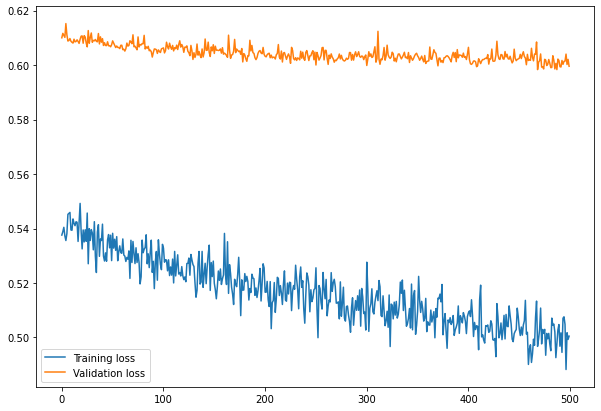

In [ ]:
from termcolor import colored
n_epochs = 500
val_losses, tot_losses = [], []

for i in range(n_epochs):
    acc, losses, f1 = [], [], []
    seq_model.train()
    for idx, (x, y) in enumerate(data_train):       
        opt.zero_grad()
        pred = seq_model(x.float())
        #print(pred.shape)
        loss = criterion(pred, y)
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        pred_0_1 = torch.round(torch.sigmoid(pred))
        num_corrects = torch.sum(torch.eq(pred_0_1, y))
        acc.append(100.0 * num_corrects.item()/len(y))
        
        f1.append(f1_score(y.detach().numpy(), pred_0_1.detach().numpy(), zero_division=0))
    
    tot_acc = np.mean(acc)
    val_loss, val_acc, val_f1 = eval_model(seq_model, criterion, data_val)
    val_losses.append(val_loss)
    tot_losses.append(np.mean(losses))
    f1_mean = np.mean(f1)
    
    if i % 10 == 0 :
        print(f'Epoch {i} : training loss = {tot_losses[-1]}, train accuracy = {np.round(tot_acc, 2)}, f1 score = {f1_mean:.4f}')
    if (i % 35 == 0):
        print(colored("--"*50, 'blue'))
        print(colored(f"Epoch {i} : validation loss = {val_loss}, validation accuracy = {np.round(val_acc, 2)}, f1 score = {val_f1:.4f}", 'blue'))
        print(colored("--"*50, 'blue'))

plt.figure(figsize=(10, 7))
plt.plot(np.array(tot_losses), label="Training loss")
plt.plot(np.array(val_losses), label="Validation loss")
plt.legend()
plt.show()

In [ ]:
val_loss, val_acc, _ = eval_model(seq_model, criterion, data_val)
val_acc

66.87898089171975

In [ ]:
seq_model.eval()
preds = torch.sigmoid(seq_model(torch.FloatTensor(x_test)))
pred_0_1 = np.round(preds.detach().numpy())
np.savetxt('pred_classif.txt', pred_0_1, fmt='%d')

### Regression

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Sequential_Model(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, is_reg=False):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.is_reg = is_reg
 
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, 
                            num_layers=2, bidirectional=False,
                            dropout=.3, batch_first=True)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_dim,
                          num_layers=2, dropout=.3, batch_first=True)
        
        self.fc = nn.Linear(self.hidden_dim, self.hidden_dim//2)
        self.dropout = nn.Dropout(p=0.3)
        self.bn_1 = nn.BatchNorm1d(self.hidden_dim)
        self.bn_2 = nn.BatchNorm1d(self.hidden_dim//2)
        self.linear = nn.Linear(self.hidden_dim//2, 1)

    def forward(self, seq_inputs):
        # seq_inputs is of shape : (batch_size, seq_length, embedding_dim + 1)
        n_samples = seq_inputs.size(0)
        
        (hn_t, c_t) = (torch.zeros(2, n_samples, self.hidden_dim), 
                       torch.zeros(2, n_samples, self.hidden_dim))
        #out = torch.mean(seq_inputs, axis=1)
        out, _ = self.gru(seq_inputs, hn_t)
        #out, _ = self.gru(seq_inputs, hn_t)
        out = F.elu_(self.fc(out[:,-1,:]))
        out = F.elu_(self.dropout(out))
    
        out = self.linear(out)
                
        return out.squeeze()

In [ ]:
import torch.optim as optim

seq_model = Sequential_Model(embedding_dim=x.shape[2], hidden_dim=32)
opt = optim.Adam(seq_model.parameters(), lr=1e-4, weight_decay=3e-3)

criterion = nn.MSELoss() 

In [ ]:
def eval_model(model, criterion, evalloader):
    model.eval()
    total_epoch_loss = 0
    total_epoch_rmse = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            preds = model(x.float())
            loss = criterion(preds, y.float())
            rmse = np.sqrt(loss.item())
            total_epoch_loss += loss.item()
            total_epoch_rmse += rmse

    return total_epoch_loss/(i+1), total_epoch_rmse/(i+1)

Epoch 0 : training loss = 1.115280294790864, train rmse = 1.0174
--------------------------------------------------------------------------------
Epoch 0 : validation loss = 0.7034569382667542, validation rmse = 0.8387
--------------------------------------------------------------------------------
Epoch 10 : training loss = 0.349614231614396, train rmse = 0.5532
Epoch 20 : training loss = 0.22961556853260845, train rmse = 0.4572
Epoch 30 : training loss = 0.22493328771088272, train rmse = 0.4544
--------------------------------------------------------------------------------
Epoch 35 : validation loss = 0.09504920244216919, validation rmse = 0.3083
--------------------------------------------------------------------------------
Epoch 40 : training loss = 0.17692058417014778, train rmse = 0.4023
Epoch 50 : training loss = 0.1711682395543903, train rmse = 0.3934
Epoch 60 : training loss = 0.17351313156541437, train rmse = 0.3978
Epoch 70 : training loss = 0.15577889163978398, train rmse

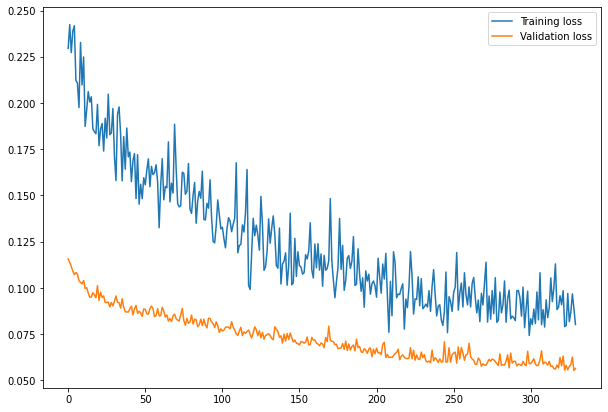

In [ ]:
from termcolor import colored
n_epochs = 350
val_losses, tot_losses = [], []

for i in range(n_epochs):
    rmse, losses = [], []
    seq_model.train()
    for idx, (x, y) in enumerate(data_train):       
        opt.zero_grad()
        pred = seq_model(x.float())
        #print(pred.shape)
        loss = criterion(pred, y.float())
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        rmse.append(np.sqrt(loss.item()))
    
    tot_rmse = np.mean(rmse)
    val_loss, val_rmse = eval_model(seq_model, criterion, data_val)
    val_losses.append(val_loss)
    tot_losses.append(np.mean(losses))
    
    if i % 10 == 0 :
        print(f'Epoch {i} : training loss = {tot_losses[-1]}, train rmse = {tot_rmse:.4f}')
    if (i % 35 == 0):
        print(colored("--"*40, 'blue'))
        print(colored(f"Epoch {i} : validation loss = {val_loss}, validation rmse = {val_rmse:.4f}", 'blue'))
        print(colored("--"*40, 'blue'))

plt.figure(figsize=(10, 7))
plt.plot(np.array(tot_losses[20:]), label="Training loss")
plt.plot(np.array(val_losses[20:]), label="Validation loss")
plt.legend()
plt.show()

Export predictions in .txt

In [ ]:
val_loss, val_rmse = eval_model(seq_model, criterion, data_val)
val_rmse

0.23751575204411576

In [ ]:
seq_model.eval()
preds = seq_model(torch.FloatTensor(x_test))
np.savetxt('pred_reg.txt', preds.detach().numpy(), fmt='%.17f')